In [287]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

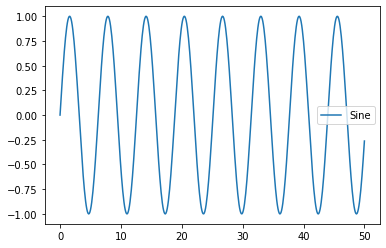

In [289]:
X = np.linspace(0, 50, 501)
y = np.sin(X)
df = pd.DataFrame(y, index=X, columns=['Sine'])
df.plot();

In [290]:
test_percent = 0.1

In [291]:
test_point = np.round(len(df) * test_percent)
test_point

50.0

In [292]:
test_ind = int(len(df) - test_point)
test_ind

451

In [293]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.shape, test.shape

((451, 1), (50, 1))

In [294]:
test.head(3)

,Sine
45.1,0.899097
45.2,0.938307
45.3,0.968142


In [295]:
pd.concat([train.head(3), test.head(3)], keys=['train first 3', 'test first 3'])

Sine
train first 3 0.0   0.000000
              0.1   0.099833
              0.2   0.198669
test first 3  45.1  0.899097
              45.2  0.938307
              45.3  0.968142

In [296]:
from sklearn.preprocessing import MinMaxScaler

In [297]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [298]:
(scaled_train.max(), scaled_train.min()), (scaled_test.max(), scaled_test.min())

((0.9999999999999999, 0.0), (0.9994531695555238, 2.162577984854419e-06))

In [299]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [300]:
length = 50 # should be set such that it captures the seasonality of the data
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [301]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [302]:
n_features = 1

In [303]:
model = Sequential()

model.add(SimpleRNN(units=50, input_shape=(length, n_features)))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [304]:
model.fit_generator(generator=generator, epochs=5)

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


401/401 [==============================] - 3s 6ms/step - loss: 0.0353
Epoch 2/5
401/401 [==============================] - 3s 6ms/step - loss: 1.6372e-04
Epoch 3/5
401/401 [==============================] - 3s 6ms/step - loss: 1.1279e-04
Epoch 4/5
401/401 [==============================] - 2s 6ms/step - loss: 6.2656e-05
Epoch 5/5
401/401 [==============================] - 2s 6ms/step - loss: 4.8310e-04


<AxesSubplot:>

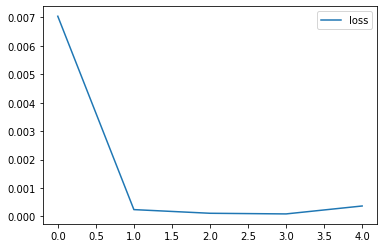

In [305]:
losses = pd.DataFrame(model.history.history)

losses.plot()

In [306]:
first_evaluation_batch = scaled_train[-length:]
first_evaluation_batch.shape

(50, 1)

In [307]:
first_evaluation_batch = first_evaluation_batch.reshape((1, length, n_features))
first_evaluation_batch.shape

(1, 50, 1)

In [308]:
model.predict(first_evaluation_batch)

array([[0.96718216]], dtype=float32)

In [309]:
scaled_test[0]

array([0.94955134])

In [310]:
test_predictions = []

first_evaluation_batch = scaled_train[-length:]

current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [311]:
true_predictions = scaler.inverse_transform(test_predictions)

test['predictions'] = true_predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

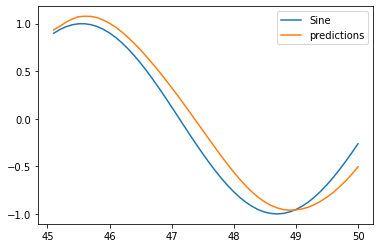

In [312]:
test.plot()

In [313]:
from tensorflow.keras.callbacks import EarlyStopping

In [314]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [315]:
length = 49

generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test, targets=scaled_test, 
                                           length=length, batch_size=1)


In [316]:
model = Sequential()

model.add(LSTM(50, input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [317]:
model.fit_generator(generator=generator, epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
402/402 [==============================] - 7s 15ms/step - loss: 0.1013 - val_loss: 1.1604e-04
Epoch 2/20
402/402 [==============================] - 5s 13ms/step - loss: 6.7930e-05 - val_loss: 3.3557e-05
Epoch 3/20
402/402 [==============================] - 5s 13ms/step - loss: 5.7994e-05 - val_loss: 1.0188e-05
Epoch 4/20
402/402 [==============================] - 5s 12ms/step - loss: 6.0813e-05 - val_loss: 1.3379e-04
Epoch 5/20
402/402 [==============================] - 5s 11ms/step - loss: 3.7090e-04 - val_loss: 1.0244e-05


In [318]:
test_predictions = []

first_evaluation_batch = scaled_train[-length:]

current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [319]:
true_predictions = scaler.inverse_transform(test_predictions)

test['LSTM Predictions'] = true_predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

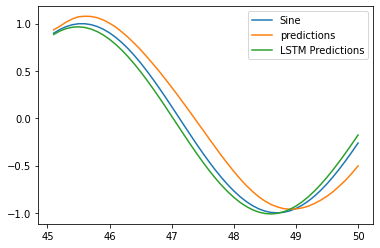

In [320]:
test.plot()

In [321]:
full_scaler = MinMaxScaler()
scaled_X = full_scaler.fit_transform(df)

In [322]:
length = 50
full_generator = TimeseriesGenerator(data=scaled_X, targets=scaled_X,
                                     length=length, batch_size=1)

In [324]:
n_features = 1

model = Sequential()

model.add(LSTM(units=50, input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [325]:
model.fit_generator(full_generator, epochs=6)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
451/451 [==============================] - 8s 14ms/step - loss: 0.0495
Epoch 2/6
451/451 [==============================] - 6s 14ms/step - loss: 2.2186e-04
Epoch 3/6
451/451 [==============================] - 6s 13ms/step - loss: 9.3084e-05
Epoch 4/6
451/451 [==============================] - 5s 12ms/step - loss: 3.8837e-04
Epoch 5/6
451/451 [==============================] - 5s 12ms/step - loss: 4.7909e-05
Epoch 6/6
451/451 [==============================] - 5s 12ms/step - loss: 9.1999e-05


In [329]:
forecast = []

first_eval_batch = scaled_X[-length:]

currnt_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(25):
    
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],
                              [[current_pred]],
                              axis=1)

In [332]:
forecast = full_scaler.inverse_transform(forecast)

In [336]:
50 + len(forecast) * 0.1

52.5

In [338]:
forecast_ind = np.arange(50.1, 
          50.1 + len(forecast) * 0.1,
          step=0.1)
len(forecast_ind), forecast_ind

(25,
 array([50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 50.8, 50.9, 51. , 51.1,
        51.2, 51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52. , 52.1, 52.2,
        52.3, 52.4, 52.5]))

In [340]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_ind, columns=['Sine'])

<AxesSubplot:>

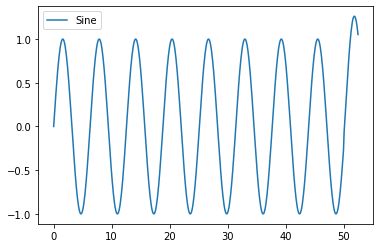

In [342]:
pd.concat([df, forecast_df]).plot()